In [ ]:
# scikit-learn playground 

In [1]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


df = pd.read_csv('data/chr20_out.tsv', sep='\t', encoding = "UTF-8")
df = df.set_index(['chr','pos', 'ref', 'alt']) #index by identifier
#print(df.to_string()) ## will print the whole dataframe
#df.plot.hist()

print("shape before", df.shape)
df['FATHMM_score'] = df['FATHMM_score'].replace({'.': np.nan})
df['MetaSVM_score'] = df['MetaSVM_score'].replace({'.': np.nan})  # find a generalized way to replace
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
df.head()

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}


df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

df= df.drop(columns=['clinvar_clnsig', 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

print("shape after dropping Unk", df.shape)
df.head()

shape before (3337, 4)
shape after dropping all data with score = '.' (2114, 4)
shape after dropping Unk (695, 3)


FATHMM_score MetaSVM_score  Problematic
chr pos    ref alt                                        
20  420896 A   G           2.24       -1.1321            0
    427395 G   T          -5.92        1.0422            1
    427443 A   G          -0.25       -0.2616            1
    447909 T   C           2.83       -0.9040            0
    967230 C   T          -4.47        1.1001            1

In [2]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                     FATHMM_score MetaSVM_score  Problematic
chr pos      ref alt                                        
20  63349880 C   A          -1.28       -0.8864            0
    45894002 T   C          -0.47        0.2782            1
    5302226  C   T          -0.61       -0.1746            1

Test data subset

                    FATHMM_score MetaSVM_score  Problematic
chr pos     ref alt                                        
20  968019  C   G          -2.06        0.5258            1
    1980372 C   T          -2.13        0.4429            0
    1980513 T   A           -1.6       -0.5999            0


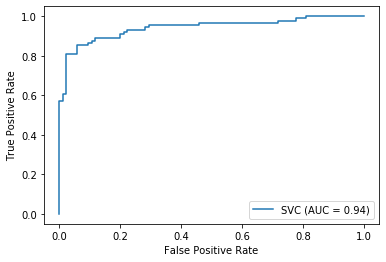

In [11]:
## Try a binary support vector machine:

classifier1 = SVC(kernel='rbf', gamma='scale',random_state=42) # default for kernel and gamma. AUC = 0.94
classifier2 = SVC(kernel='linear', gamma=10 ,random_state=42) # 0.94
classifier3 = SVC(kernel='sigmoid', gamma=10 ,random_state=42) # 0.82

classifier1.fit(df_train, train_labels)
svc_disp = plot_roc_curve(classifier1, df_test, test_labels)
plt.show()

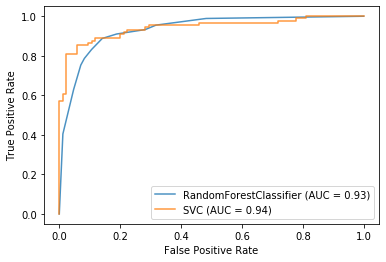

In [4]:
# Try a random forest:

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, df_test, test_labels, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()